# Step 0: Imports

In [5]:
# imports
import numpy as np
from collections import deque
import pickle
from tqdm import tqdm
np.random.seed(42)

import torch
import torch.nn as nn
import pickle
from math import sqrt
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
torch.manual_seed(42)

import os

print("imports complete")

imports complete


In [6]:
SEQ_LEN = 32

PAD_TOKEN = 0
AVG_DEG = 2
MAX_VTXS = SEQ_LEN//AVG_DEG - 1
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

INF = MAX_VTXS # represents unreachability

# Step 1: Generate synthetic data

In [ ]:
# original task data
NTRAIN1 = 100_000
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)

# the label is the shortest distance from vtx 1 to vtx 2
# or "INF" if no path exists

# fine tuning data
NTRAIN2 = 2000
# I haven't totally figured out how to do the fine tuning yet.
# So don't worry about this yet.

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = np.random.randint(n, size=(AVG_DEG*(n-1)))+1
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [u,v]
            adjacencies[u].add(v)
            adjacencies[v].add(u)

    if np.random.random() < 0.25:
      edge_list += [1,2]
      adjacencies[1].add(2)
      adjacencies[2].add(1)

    edge_list += [PAD_TOKEN]*(SEQ_LEN-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [INF]+[d(1,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(G, target=None):
    dist = [INF for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == INF:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def fake_SSSP(G, target=None):
    return 2 in G[1]

graphs1 = []
distance1 = []

graphs2 = []
distances2 = []

for n in tqdm(range(MAX_VTXS-1, MAX_VTXS)):
    # for _ in range(NTRAIN1//MAX_VTXS):
    for _ in range(NTRAIN1):
        edge_list, adj_list = random_graph(n)
        dist = SSSP(adj_list, target=2)

        graphs1.append(edge_list)
        distance1.append(dist)

# for n in range(8, MAX_VTXS//4):
#     for _ in range(NTRAIN2//MAX_VTXS):
#         edge_list, adj_list = random_graph(n)
#         distances = SSSP(adj_list)
#         graphs2.append(edge_list)
#         distances2.append(distances)

split1 = int(len(graphs1)*3/4)
split2 = int(len(graphs2)*3/4)

all1 = list(zip(graphs1, distance1))
np.random.shuffle(all1)
graphs1, distance1 = zip(*all1)

data = {
    "train1-data": graphs1[:split1],
    "train1-labels": distance1[:split1],
    "test1-data": graphs1[split1:],
    "test1-labels": distance1[split1:]
    # "train2-data": graphs2[:split2],
    # "train2-labels": distances2[:split2],
    # "test2-data": graphs2[split2:],
    # "test2-labels": distances2[split2:]
}

with open('data.pkl', 'wb') as file:
    pickle.dump(data, file)



100%|██████████| 1/1 [00:14<00:00, 14.42s/it]


In [74]:
NTRAIN1 = 100000

graphs1 = torch.randint(1, MAX_VTXS, (NTRAIN1, SEQ_LEN))

# check if token 1 is in the graph
def silly_distance(graph):
    return int(1 in graph)

# check if both token 1 and token 2 are in the graph
def silly_distance2(graph):
    return int(1 in graph and 2 in graph and 3 in graph and 4 in graph and 5 in graph)

def silly_distance3(graph):
    for i in range(len(graph)//2):
        if graph[2*i] + graph[2*i+1] == 3:
            return 1
    return 0

distance1 = [silly_distance3(graph) for graph in graphs1]

split1 = int(len(graphs1)*3/4)

data = {
    "train1-data": graphs1[:split1],
    "train1-labels": distance1[:split1],
    "test1-data": graphs1[split1:],
    "test1-labels": distance1[split1:]
}

print(data["train1-data"].shape)

with open('data.pkl', 'wb') as file:
    pickle.dump(data, file)

print("DONE")


torch.Size([75000, 32])
DONE


In [76]:
sum(distance1)/len(distance1)

0.1518

0.1518

In [77]:
print(f"dataset size = {os.path.getsize('data.pkl')//(1024*1024)}MB")

dataset size = 49MB


# Step 2: Define Transformer Model

In [107]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, device, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, model_dim//2)
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.device = device

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc_out = nn.Linear(model_dim*seq_len, output_dim)
        self.fancy_encoding = torch.repeat_interleave(torch.rand((1,SEQ_LEN // 2, model_dim // 2), device=device), 2, dim=1)
    
    def positional_encoding(self, batch_size):
        position = torch.arange(self.seq_len, dtype=torch.float, device=self.device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.model_dim, 2, dtype=torch.float, device=self.device) *
                            -(torch.log(torch.tensor(500.0)) / self.model_dim))

        pos_encoding = torch.zeros(self.seq_len, self.model_dim, device=self.device)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        pos_encoding = pos_encoding.unsqueeze(0).repeat(batch_size, 1, 1)
        return pos_encoding

    def forward(self, src, key_padding_mask):
        batch_size, src_len = src.size(0), src.size(1)
        # src_pos = self.positional_encoding(batch_size)
        embed = self.embedding(src)
        src = torch.cat((embed * sqrt(self.model_dim), torch.Tensor.repeat(self.fancy_encoding, (batch_size, 1, 1))), dim=2)

        output = self.transformer_encoder(src, None, src_key_padding_mask=key_padding_mask)
        flat_output = torch.flatten(output, start_dim=1, end_dim=2)
        output = self.fc_out(flat_output)
        return output


# Step 3: Load Data

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CUDA is not available. Please check your GPU setup."

# PARAMS
VOCAB_SIZE = 1+MAX_VTXS # one more than the max number of vertices
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 50
BSZ = 512
LR = 0.001
NHEADS = 4
NLAYERS = 2
PAD_TOKEN = 0
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         device=device).to(device)

with open("data.pkl", "rb") as f:
    data = pickle.load(f)

train_data1 = data["train1-data"]
train_label1 = data["train1-labels"]
train_data_tensor = torch.tensor(train_data1, dtype=torch.long, device=device)
train_label_tensor = torch.tensor(train_label1, dtype=torch.float, device=device)
train_padding_mask = (train_data_tensor == PAD_TOKEN).bool().to(device)
train_dataset = TensorDataset(train_data_tensor, train_label_tensor, train_padding_mask)
train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True)

test_data1 = data["test1-data"]
test_label1 = data["test1-labels"]
test_data_tensor = torch.tensor(test_data1, dtype=torch.long, device=device)
test_label_tensor = torch.tensor(test_label1, dtype=torch.float, device=device)
test_padding_mask = (test_data_tensor == PAD_TOKEN).bool().to(device)
test_dataset = TensorDataset(test_data_tensor, test_label_tensor, test_padding_mask)
test_loader = DataLoader(test_dataset, batch_size=BSZ, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_err = []
test_err = []

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters in the model: {trainable_params//1000}K")

train_baseline = ((train_label_tensor - train_label_tensor.mean())**2).mean().item()
print(f"train BASELINEs: {train_baseline:.4f}")

Trainable parameters in the model: 102K
train BASELINEs: 0.1290


/tmp/ipykernel_390590/1991115476.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.tensor(train_data1, dtype=torch.long, device=device)
/tmp/ipykernel_390590/1991115476.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(test_data1, dtype=torch.long, device=device)


# Step 4: Train the Model for the first task

Epoch 1/50 	 Train Err: 0.1621 	 Test Err: 0.1208 	 baseline err: 0.1290
Epoch 2/50 	 Train Err: 0.1266 	 Test Err: 0.1201 	 baseline err: 0.1290
Epoch 3/50 	 Train Err: 0.1224 	 Test Err: 0.1199 	 baseline err: 0.1290
Epoch 4/50 	 Train Err: 0.1190 	 Test Err: 0.1214 	 baseline err: 0.1290
Epoch 5/50 	 Train Err: 0.1167 	 Test Err: 0.1164 	 baseline err: 0.1290
Epoch 6/50 	 Train Err: 0.1154 	 Test Err: 0.1156 	 baseline err: 0.1290
Epoch 7/50 	 Train Err: 0.1146 	 Test Err: 0.1131 	 baseline err: 0.1290
Epoch 8/50 	 Train Err: 0.1140 	 Test Err: 0.1145 	 baseline err: 0.1290
Epoch 9/50 	 Train Err: 0.1135 	 Test Err: 0.1144 	 baseline err: 0.1290
Epoch 10/50 	 Train Err: 0.1134 	 Test Err: 0.1160 	 baseline err: 0.1290
Epoch 11/50 	 Train Err: 0.1134 	 Test Err: 0.1160 	 baseline err: 0.1290
Epoch 12/50 	 Train Err: 0.1129 	 Test Err: 0.1137 	 baseline err: 0.1290
Epoch 13/50 	 Train Err: 0.1131 	 Test Err: 0.1122 	 baseline err: 0.1290
Epoch 14/50 	 Train Err: 0.1125 	 Test Err: 0.1

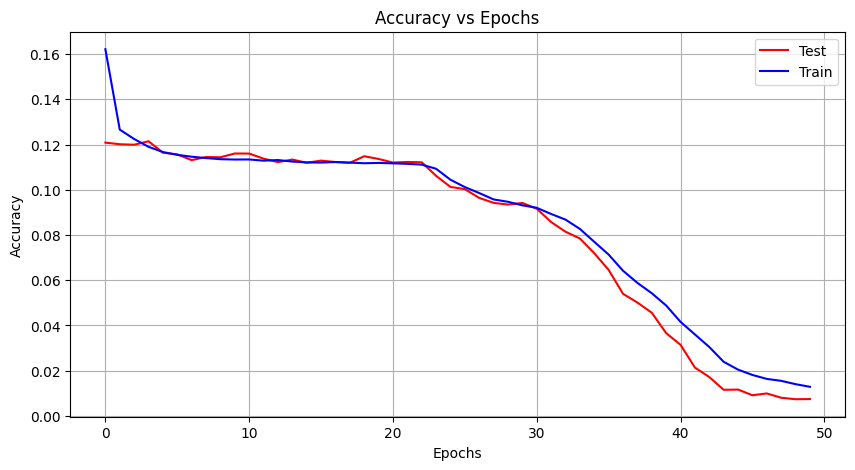

In [122]:
for epoch in range(NEPOCHS):
    model.train() # set to training mode
    train_loss = 0

    for batch_src, batch_labels, batch_padding_mask in train_loader:
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item()/len(train_loader)
        loss.backward()
        optimizer.step()

    # Evaluate performance
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_src, batch_labels, batch_padding_mask in test_loader:
            output = model(batch_src, batch_padding_mask)
            loss = criterion(output.squeeze(1), batch_labels)
            test_loss += loss.item()/len(test_loader)

    test_err.append(test_loss)
    train_err.append(train_loss)
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f} \t baseline err: {train_baseline:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(test_err, label='Test', color='red')
plt.plot(train_err, label='Train', color='blue')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid()
plt.show()

In [ ]:
## Q: why is this not working so well?

## maybe first try a simpler problem: just give it points for distinguishing between distance 1 or not

In [47]:
batch_src, batch_labels, batch_padding_mask = next(iter(train_loader))
output = model(batch_src, batch_padding_mask)

In [33]:
for x,y in zip(batch_labels.tolist(),  output.squeeze(1).tolist()):
  print(f"{int(x)} \t {y:.1f}")

1 	 nan
1 	 nan
1 	 nan
1 	 nan
0 	 nan
0 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan
0 	 nan
1 	 nan
0 	 nan
1 	 nan
1 	 nan
0 	 nan
1 	 nan
1 	 nan
0 	 nan
1 	 nan
1 	 nan
1 	 nan
1 	 nan


In [ ]:
batch_src[2]

# Step 5: Fine Tune

# Step 6: Test generalization